In [1]:
!pip install torchview

In [2]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plt
import graphviz
from torchview import draw_graph
import time

In [3]:
batch_size = 64
norm_params = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

transform_train = transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*norm_params),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(*norm_params)])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print("Class names: {}".format(classes))

Class names: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Number of train samples: 50000
Number of test samples: 10000


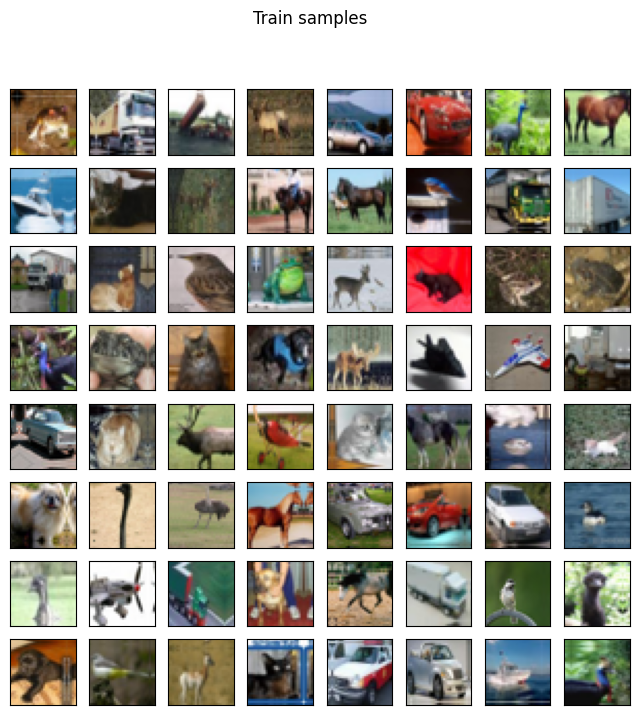

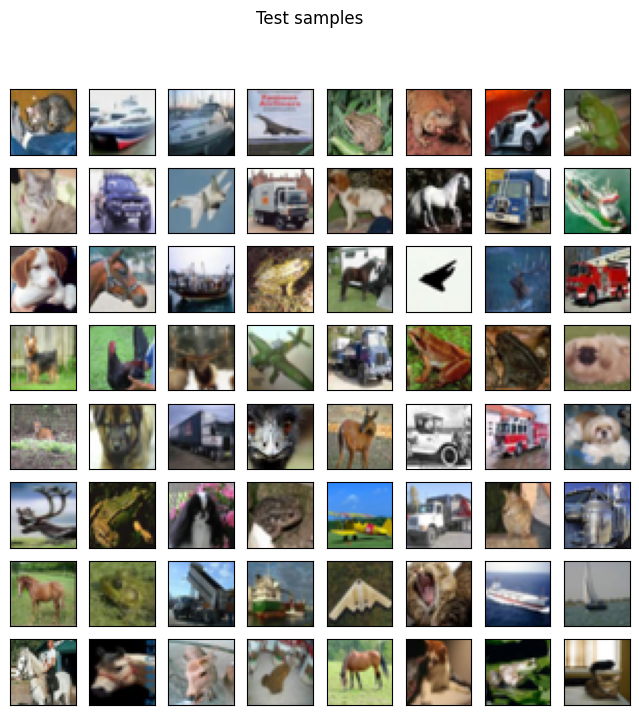

In [5]:
def denormal(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means

def show_img(images, title):
    img_x = 8
    img_y = 8

    figsize = (8, 8)
    fig, axes = plt.subplots(img_y, img_x, figsize = figsize)
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = denormal(images[i][0], *norm_params)
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))

print('Number of train samples: {}'.format(len(trainset)))
show_img(trainset, 'Train samples')

print('Number of test samples: {}'.format(len(testset)))
show_img(testset, 'Test samples')

In [6]:
print(f"X_train: {trainset.data.shape}")
print(f"Y_train: {len(trainset.targets)}")
print(f"X_test: {testset.data.shape}")
print(f"Y_test: {len(testset.targets)}")

X_train: (50000, 32, 32, 3)
Y_train: 50000
X_test: (10000, 32, 32, 3)
Y_test: 10000


In [7]:
class CNN(torch.nn.Module) :
    def __init__(self) :
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.norm1 = torch.nn.BatchNorm2d(64)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.norm2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.norm3 = torch.nn.BatchNorm2d(256)

        self.activation = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2)
        self.linear1 = torch.nn.Linear(256 * 4 * 4, 1000)
        self.linear2 = torch.nn.Linear(1000, 10)

        self.dropout = torch.nn.Dropout(0.2)
        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        out = self.activation(self.conv1(x))
        out = self.pool(out)
        out = self.norm1(out)
        out = self.activation(self.conv2(out))
        out = self.pool(out)
        out = self.norm2(out)
        out = self.activation(self.conv3(out))
        out = self.pool(out)
        out = self.norm3(out)
        out = self.flatten(out)
        out = self.activation(self.linear1(out))
        out = self.dropout(out)
        out = self.linear2(out)
        return out

In [8]:
cnn_model = CNN()
cnn_model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=4096, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

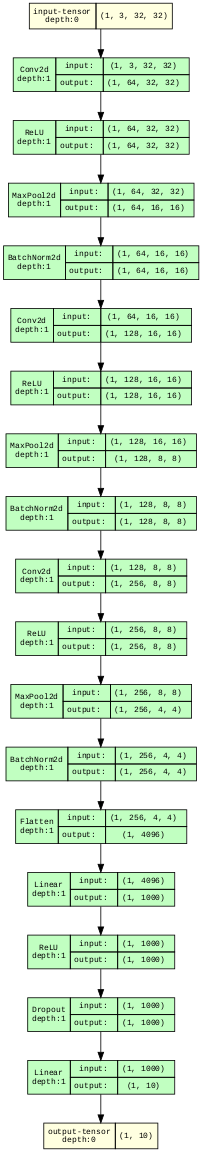

In [9]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(cnn_model, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

In [10]:
learning_rate = 0.001
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = learning_rate)

def get_accuracy(model, data_loader):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader):
    loss = 0
    n = 0
    with torch.no_grad():
        losses = []
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            losses.append(loss)
    return torch.stack(losses).mean()

start_time = time.time()
for epoch in range(num_epochs):
    start_epoch = time.time()
    losses = []
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()

        losses.append(loss)

        loss.backward()
        optimizer.step()

    total_time_epoch = time.time() - start_epoch
    print('Epoch[{}]: Loss = {:.4f}, Train accuracy = {:.4f}, Time epoch = {:.4f}'.
          format(epoch + 1,
                 torch.stack(losses).mean(),
                 get_accuracy(cnn_model, trainloader),
                 total_time_epoch))
total_time = time.time() - start_time
print('Total time {}'.format(total_time))

Epoch[1]: Loss = 1.2864, Train accuracy = 0.6422, Time epoch = 254.7091
Epoch[2]: Loss = 0.9040, Train accuracy = 0.7325, Time epoch = 244.3712
Epoch[3]: Loss = 0.7688, Train accuracy = 0.7737, Time epoch = 242.2247
Epoch[4]: Loss = 0.6825, Train accuracy = 0.7885, Time epoch = 240.0825
Epoch[5]: Loss = 0.6247, Train accuracy = 0.8041, Time epoch = 247.7661
Epoch[6]: Loss = 0.5784, Train accuracy = 0.8241, Time epoch = 241.4314
Epoch[7]: Loss = 0.5368, Train accuracy = 0.8242, Time epoch = 241.7482
Epoch[8]: Loss = 0.5036, Train accuracy = 0.8363, Time epoch = 240.8035
Epoch[9]: Loss = 0.4793, Train accuracy = 0.8525, Time epoch = 242.1532
Epoch[10]: Loss = 0.4512, Train accuracy = 0.8639, Time epoch = 240.8618
Total time 3480.720684528351


In [11]:
print('Loss = {:.4f}, Test accuracy = {:.4f}'.format(
    get_loss(cnn_model, testloader),
    get_accuracy(cnn_model, testloader)))

Loss = 81.7286, Test accuracy = 0.8279


In [ ]:
!jupyter nbconvert